# Improving a Model by Tuning Hyperparameters

First predictions = baseline predictions.

First model = baseline model

From a data perspective:
* Could we collect more data? (generally, the more data, the better)
* Could we improve our data?

From a model perspective:
* Is there a better model we could use?
* Could we improve the current model?

Hyperparameters vs. Parameters
* Parameters = patterns in data that the model finds
* Hyperparameters = settings of a model you can adjust to (potentially) improve its ability to find patterns

Three ways to adjust hyperparameters:
1. By hand
2. Randomly with RandomSearchCV
3. Exhaustively with GridSearchCV

## Get Data

In [55]:
import pandas as pd
import numpy as np

In [56]:
# Classification data
heart_disease = pd.read_csv('data/heart-disease.csv')
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Helper Functions

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_preds_classification(y_true, y_preds):
  """
  Performs evaluation comparison on y_true labels vs. y_pred labels on a classification model
  """
  accuracy = accuracy_score(y_true, y_preds)
  precision = precision_score(y_true, y_preds)
  recall = recall_score(y_true, y_preds)
  f1 = f1_score(y_true, y_preds)
  
  print(f'Accuracy: {accuracy * 100:.2f}%')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1-Score: {f1:.2f}')
  
  metric_dict = {'accuracy': round(accuracy, 2),
                 'precision': round(precision, 2),
                 'recall': round(recall, 2),
                 'f1': round(f1, 2)}

  return metric_dict

## 1. Tuning Hyperparameters by Hand

<img style="width: 500px;" src="data/validation-set-img.png">

We need a validation set (which is a section of the training data) and cannot use the test set because we should not be using any of the test set to make decisions on our model, else it could result in data leakage.

The validation set serves as a practice exam for the model while the test set is the real exam which the model hasn't seen before.

Let's make 3 sets, training, validation, and test.

In [59]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(42)

# Shuffling the data
heart_disease_shuffled = heart_disease.sample(frac=1)

# Split data into X & y
X = heart_disease_shuffled.drop(['target'], axis=1)
y = heart_disease_shuffled['target']

# Splitting data into training, validation, and testing sets
train_split = round(0.7 * len(heart_disease_shuffled)) # 70% of data
valid_split = round(train_split + 0.15 * len(heart_disease_shuffled)) # Next 15% of data

X_train, y_train = X[:train_split], y[:train_split]
X_valid, y_valid = X[train_split:valid_split], y[train_split:valid_split]
X_test, y_test = X[valid_split:], y[valid_split:]

# Fit model on training set
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make baseline predictions on validation set using classifier
y_preds = clf.predict(X_valid)

In [60]:
baseline_metrics = evaluate_preds_classification(y_valid, y_preds)
baseline_metrics

Accuracy: 82.22%
Precision: 0.81
Recall: 0.88
F1-Score: 0.85


{'accuracy': 0.82, 'precision': 0.81, 'recall': 0.88, 'f1': 0.85}

In [61]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

We're going to try and adjust the following hyperparameters:
* `max_depth`
* `max_features`
* `min_samples_leaf`
* `min_samples_split`
* `n_estimators`

In [62]:
# Create a second classifier with different hyperparameters

np.random.seed(42)
clf_2 = RandomForestClassifier(max_depth=10)
clf_2.fit(X_train, y_train)

# Predictions
y_preds_2 = clf_2.predict(X_valid)

# Getting metrics
clf_2_metrics = evaluate_preds_classification(y_valid, y_preds_2)

Accuracy: 80.00%
Precision: 0.81
Recall: 0.84
F1-Score: 0.82


Although we can perform these experiments on the hyperparameters by hand, it will take us a long time... which is why we go onto the next method

## 2. Tuning Hyperparameters Randomly with RandomSearchCV

RandomSearchCV will try a specified number of models with random hyperparameter settings (based on your grid) and return the best model

As a reminder, we're going to try and adjust the following hyperparameters:
* `max_depth`
* `max_features`
* `min_samples_leaf`
* `min_samples_split`
* `n_estimators`

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

grid = {'max_depth': [None, 5, 10, 20, 30], 
        'max_features': ['auto', 'sqrt'], 
        'min_samples_leaf': [1, 2, 4], 
        'min_samples_split': [2, 4, 6], 
        'n_estimators': [10, 100, 200, 500, 1000, 1200]}

np.random.seed(42)

# Split into X & y
X = heart_disease_shuffled.drop('target', axis=1)
y = heart_disease_shuffled['target']

# Split into train and test sets
# We don't need to make validation sets because the RandomizedSearchCV will make validation sets for us out of the training data
# When we train the model on the training data, RandomizedSearchCV takes out a validation set to evaluate on and switches it cv number of times
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Instantiate classifier
clf = RandomForestClassifier()

# Setup RandomizedSearchCV
# n_iter is the number of models to try 
  # Ex. it will try n_iter number of models with random selections of the hyperparameters from the grid
# cv is the number of splits you want it to do for each iteration
  # It is similar to cross_val_score but now, it also takes out a validation set from the training set
rs_clf = RandomizedSearchCV(estimator=clf, param_distributions=grid, n_iter=10, cv=5, verbose=2)

# Fit the RandomizedSearchCV version of clf
rs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   1.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   1.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   1.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   1.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200; total time=   1.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples

c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END max_depth=None,

c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.1s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.2s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.3s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.3s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000; total time=   1.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000; total time=   1.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000; total time=   1.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000; total time=   1.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000; total time=   1.2s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 1200]},
                   verbose=2)

In [64]:
rs_clf.best_params_, rs_clf.best_score_

({'n_estimators': 200,
  'min_samples_split': 6,
  'min_samples_leaf': 2,
  'max_features': 'sqrt',
  'max_depth': None},
 0.8306972789115648)

In [65]:
# Make predictions with the best hyperparameters 
rs_y_preds = rs_clf.predict(X_test)
rs_metrics = evaluate_preds_classification(y_test, rs_y_preds)

Accuracy: 81.97%
Precision: 0.77
Recall: 0.86
F1-Score: 0.81


## 3. Tuning Hyperparameters Exhaustively with GridSearchCV

GridSearchCV will take every possible setting from the grid and test all of them to find the best model

In [66]:
grid

{'max_depth': [None, 5, 10, 20, 30],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 4, 6],
 'n_estimators': [10, 100, 200, 500, 1000, 1200]}

If we did GridSearchCV with the grid above, then it would have to fit the model 5 * 2 * 3 * 3 * 6 * 5 = 2700 times which is very computationally expensive. So, we need to make another grid so that GridSearchCV can work in a reasonable amount of time. Since we found some good parameters from RandomSearchCV, we can make it so that our grid parameters are closer to the good parameters we got from RandomSearchCV.

In [67]:
grid_2 = {'max_depth': [None],
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': [1, 2],
          'min_samples_split': [6],
          'n_estimators': [100, 200, 500]}

In [68]:
from sklearn.model_selection import GridSearchCV
np.random.seed(42)

# Setup GridSearchCV
# We don't need to make validation sets because the GridSearchCV will make validation sets for us out of the training data
# When we train the model on the training data, GridSearchCV takes out a validation set to evaluate on and switches it cv number of times
gs_clf = GridSearchCV(estimator=clf, param_grid=grid_2, cv=5, verbose=2)

# Fit the GridSearchCV version of clf
gs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.3s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.6s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.5s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.5s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.6s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.1s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.1s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.4s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.6s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.8s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.9s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.6s


c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None,

c:\Users\Mohit\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2], 'min_samples_split': [6],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [69]:
gs_clf.best_params_, gs_clf.best_score_

({'max_depth': None,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 100},
 0.8390306122448979)

In [70]:
gs_y_preds = gs_clf.predict(X_test)
gs_metrics = evaluate_preds_classification(y_test, gs_y_preds)

Accuracy: 81.97%
Precision: 0.77
Recall: 0.86
F1-Score: 0.81


## Let's Compare our Different Models' Metrics

NOTE: Technically, this graph isn't absolutely correct because the baseline metrics are based on a different split of data when compared to the other metrics...

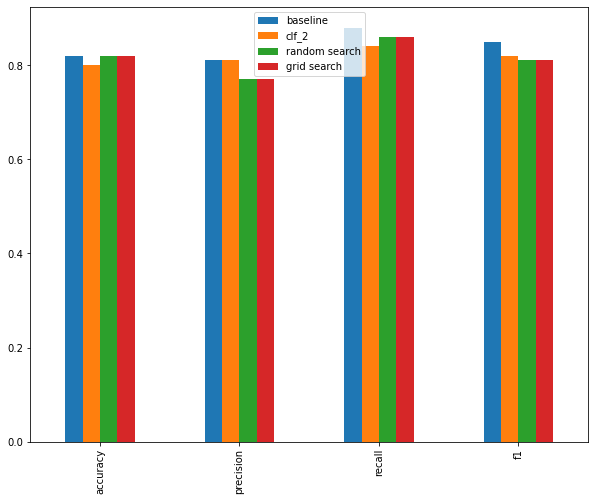

In [74]:
compare_metrics = pd.DataFrame({'baseline': baseline_metrics,
                                'clf_2': clf_2_metrics,
                                'random search': rs_metrics,
                                'grid search': gs_metrics})

compare_metrics.plot.bar(figsize=(10, 8));